# Library and Packages Import

In [173]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import text2emotion as te

train_file, test_file = '../data/train.csv', '../data/test.csv'
train_num = 27643

# Pre-define Functions

In [3]:
def preprocessor(text):
    """
    - remove HTML tags
    - remove punctuation
    - convert to lowercase
    """
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [4]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    """
    - tokenization
    - word-stemming
    - remove stop-word
    """
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk

txt = next(get_stream(path=train_file, size=10))['Page content'][0]

# Data Pre-processing

# Basic Model

In [131]:
hashvec = HashingVectorizer(n_features=2**20, 
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
# loss='log' gives logistic regression
# clf = SGDClassifier(loss='log', max_iter=100, tol=1e-3)
clf = RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1)
batch_size = 1000
stream = get_stream(path=train_file, size=batch_size)
classes = np.array([-1, 1])
train_auc, val_auc = [], []

# we use one batch for training and another for validation in each iteration
iters = (26000 + batch_size) // (batch_size)
for i in range(iters):
    batch = next(stream)
    if batch['Page content'] is None:
        break 

    X_train, X_val, y_train, y_val = train_test_split(batch['Page content'], batch['Popularity'],
                                                        test_size=0.2, random_state=1)
    
    X_train = hashvec.transform(X_train)
    clf.fit(X_train, y_train) #, classes=classes)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    
    # validate
    score = roc_auc_score(y_val, clf.predict_proba(hashvec.transform(X_val))[:,1])
    val_auc.append(score)
    print(f'[iter:{i:2d}] val. score: {score:.4f}')

[iter: 0] val. score: 0.4871
[iter: 1] val. score: 0.5520
[iter: 2] val. score: 0.5349
[iter: 3] val. score: 0.5512
[iter: 4] val. score: 0.4675
[iter: 5] val. score: 0.5880
[iter: 6] val. score: 0.5212
[iter: 7] val. score: 0.5052
[iter: 8] val. score: 0.5150
[iter: 9] val. score: 0.5385
[iter:10] val. score: 0.4463
[iter:11] val. score: 0.5145
[iter:12] val. score: 0.5012
[iter:13] val. score: 0.5080
[iter:14] val. score: 0.5326
[iter:15] val. score: 0.4981
[iter:16] val. score: 0.5778
[iter:17] val. score: 0.4488
[iter:18] val. score: 0.5438
[iter:19] val. score: 0.4979
[iter:20] val. score: 0.5385
[iter:21] val. score: 0.5382
[iter:22] val. score: 0.5581
[iter:23] val. score: 0.5292
[iter:24] val. score: 0.5037
[iter:25] val. score: 0.4947
[iter:26] val. score: 0.4629


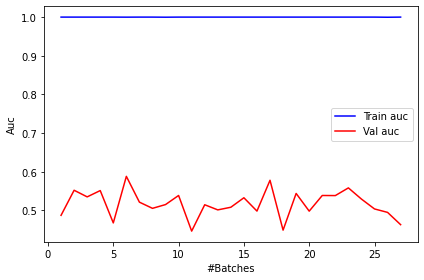

In [132]:
# Plot training curve

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

# Model Using Time Feature

In [112]:
# extract time feature
weekday_trans = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
month_trans = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr':4, 'May': 5, 'Jun': 6,
               'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

def time_feature_df(txt):
    df = pd.DataFrame(columns=['Weekday', 'Month', 'Hour', 'Minute', 'Time zone'])
    r = 'datetime="(.+?)"'
    for t in txt:
        tt = re.findall(r, t)
        try:
            weekday = 1 if weekday_trans[tt[0][:3]] >= 4 else 0
            month = 1 if month_trans[tt[0][8:11]] > 5 else 0
            hour, minute, time_zone = int(tt[0][17:19]), int(tt[0][20:22]), int(tt[0][27:29])
        except:
            weekday, month, hour, minute, time_zone = 0, 0, 12, 0, 0
        #print(f'{weekday}, {hour}:{minute}, +{time_zone}')
        row = {'Weekday': weekday, 'Month': month, 'Hour': hour, 'Minute': minute, 'Time zone': time_zone}
        df = df.append(row, ignore_index=True)
    return df.drop(columns=['Hour', 'Minute', 'Time zone'])

test = next(get_stream(path=train_file, size=50))['Page content']
df_test = time_feature_df(test)
df_test.head()

,Weekday,Month
0,0,1
1,0,0
2,0,0
3,1,1
4,0,0


In [86]:
# Test data one-hot encoding
catego_features = ['Weekday']
# category = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']
ohe = ColumnTransformer(
    [("one_hot_encoder", OneHotEncoder(sparse=False, categories='auto'), [0])],
    remainder = "passthrough"
)
df_test_ohe = ohe.fit_transform(df_test)
df_test_ohe.shape

(1000, 8)

In [125]:
pipe = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1))
                ])

#clf = SGDClassifier(loss='log', max_iter=100, tol=1e-3)
clf = RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1)

batch_size = 1000
stream = get_stream(path=train_file, size=batch_size)
classes = np.array([-1, 1])
train_auc, val_auc = [], []

iters = (26000 + batch_size) // (batch_size)
for i in range(iters):
    batch = next(stream)
    if batch['Page content'] is None:
        break 

    X_train, X_val, y_train, y_val = train_test_split(batch['Page content'], batch['Popularity'],
                                                        test_size=0.2, random_state=1)
    
    X_train = time_feature_df(X_train)
    clf.fit(X_train, y_train)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    
    # validate
    score = roc_auc_score(y_val, clf.predict_proba(time_feature_df(X_val))[:,1])
    val_auc.append(score)
    print(f'[iter:{i:2d}] val. score: {score:.4f}')

[iter: 0] val. score: 0.5030
[iter: 1] val. score: 0.5642
[iter: 2] val. score: 0.5099
[iter: 3] val. score: 0.5435
[iter: 4] val. score: 0.5642
[iter: 5] val. score: 0.5403
[iter: 6] val. score: 0.6471
[iter: 7] val. score: 0.5542
[iter: 8] val. score: 0.5340
[iter: 9] val. score: 0.5300
[iter:10] val. score: 0.4957
[iter:11] val. score: 0.6049
[iter:12] val. score: 0.5769
[iter:13] val. score: 0.5135
[iter:14] val. score: 0.5728
[iter:15] val. score: 0.5514
[iter:16] val. score: 0.5716
[iter:17] val. score: 0.5140
[iter:18] val. score: 0.5623
[iter:19] val. score: 0.5581
[iter:20] val. score: 0.5695
[iter:21] val. score: 0.5286
[iter:22] val. score: 0.5896
[iter:23] val. score: 0.6017
[iter:24] val. score: 0.5701
[iter:25] val. score: 0.5343
[iter:26] val. score: 0.5807


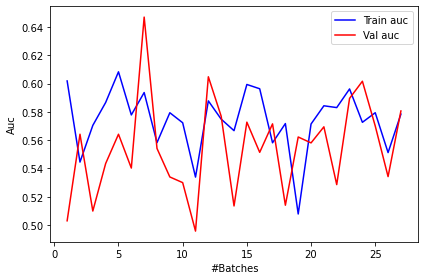

In [126]:
# Plot training curve

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

# Model Using Emotional and Time Feature

In [187]:
def time_emo_feature(txt):
    df = pd.DataFrame(columns=['Weekday', 'Month', 'Emo value'])
    r = 'datetime="(.+?)"'
    for t in txt:
        # time feature
        tt = re.findall(r, t)
        try:
            weekday = 1 if weekday_trans[tt[0][:3]] >= 4 else 0
            month = 1 if month_trans[tt[0][8:11]] > 5 else 0
        except:
            weekday, month = 0, 0
        
        # emotional feature
        bs = BeautifulSoup(t, 'html.parser')
        title = bs.find(class_="title").text
        emo_val = 0
        for v in list(te.get_emotion(title).values()):
            if type(v)==int:
                break
            emo_val += v**2 if v!=0 else 0

        row = {'Weekday': weekday,
                'Month': month,
                'Emo value': emo_val}
        df = df.append(row, ignore_index=True)

    return df

text = next(get_stream(path=train_file, size=1000))['Page content']
df_test = time_emo_feature(text)
df_test.head(10)

,Weekday,Month,Emo value
0,0.0,1.0,0.5000
1,0.0,0.0,0.6250
2,0.0,0.0,0.0000
3,1.0,1.0,0.0000
4,0.0,0.0,0.2500
5,0.0,1.0,1.0000
6,0.0,1.0,0.0000
7,0.0,1.0,0.0000
8,0.0,1.0,0.5578
9,0.0,0.0,0.0000


In [ ]:
clf = RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1)

batch_size = 1000
stream = get_stream(path=train_file, size=batch_size)
classes = np.array([-1, 1])
train_auc, val_auc = [], []

iters = train_num // batch_size
for i in range(iters):
    batch = next(stream)
    if batch['Page content'] is None:
        break 

    X_train, X_val, y_train, y_val = train_test_split(batch['Page content'], batch['Popularity'],
                                                        test_size=0.2, random_state=1)
    
    X_train = time_emo_feature(X_train)
    clf.fit(X_train, y_train)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    
    # validate
    score = roc_auc_score(y_val, clf.predict_proba(time_emo_feature(X_val))[:,1])
    val_auc.append(score)
    print(f'[iter:{i:2d}] val. score: {score:.4f}')

# Plot training curve
plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

# Testing and Output

In [189]:
# Train on all training data
# clf_test = SGDClassifier(loss='log', max_iter=100, tol=1e-3)
clf_test = RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1)

batch_size = 1000
stream = get_stream(path=train_file, size=batch_size)
classes = np.array([-1, 1])

iters = train_num // batch_size
for i in range(iters):
    batch = next(stream)
    X_train, y_train = batch['Page content'], batch['Popularity']
    if X_train is None:
        break
    
    clf_test.fit(time_emo_feature(X_train), y_train)  
    print(f'[iter:{i:2d}]')

[iter: 0]
[iter: 1]
[iter: 2]
[iter: 3]
[iter: 4]
[iter: 5]
[iter: 6]
[iter: 7]
[iter: 8]
[iter: 9]
[iter:10]
[iter:11]
[iter:12]
[iter:13]
[iter:14]
[iter:15]
[iter:16]
[iter:17]
[iter:18]
[iter:19]
[iter:20]
[iter:21]
[iter:22]
[iter:23]
[iter:24]
[iter:25]
[iter:26]


In [190]:
df_test = pd.read_csv(test_file)
df_example = pd.read_csv('../data/sample_submission.csv')
df_pred = pd.DataFrame(columns=df_example.columns)
df_pred['Id'] = df_test['Id']
df_test.shape

(11847, 2)

In [ ]:
X_test = df_test['Page content']
df_pred['Popularity'] = clf_test.predict_proba(time_emo_feature(X_test))[:,1]
df_pred.to_csv('./output/predict.csv', index=False)